In [255]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
import scipy                     
from IPython import display

import pykat
import pylab as pl
%matplotlib inline
import pandas
from pandas import DataFrame 
              

pykat.init_pykat_plotting(dpi=200)

kat=finesse.kat()
kat_PRM=finesse.kat()
kat.verbose=1
kat_PRM.verbose=1

<h2>BASECODE</h2>

<p>Input Laser ---> BS for PRM angular sensing ---> PRM ---> BS for ITM/ETM sensing ---> ITM ---> ETM</p>

In [256]:
kat.parse("""

l laser 30 0 n1                          #laser 1W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod sb1 55.556M 0.18 3 pm n2 n3         #modulator PM 55.556M 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      



################# Steering mirrors ################

#bs Steer1 1 0 0 45 n31a nSteer1refl dump1 dump2
#s Steer1toSteer2 0.5 nSteer1refl n31
#bs Steer2 1 0 0 45 nSteer2in nSteer2refl dump3 dump4
#s Steer2toBSpickoff 0 nSteer2refl n31

###################################################

##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12

attr s2 g 45                                 #guoy phase for det1
attr sQPD1 g 56.100                                 #guoy phase for det1
attr sQPD2 g 146.1                                #guoy phase for det2

pd1 QPDrefl1 166.668M 236.65738162 a11                       #Split detector1 refl
pdtype QPDrefl1 x-split   
pd1 QPDrefl2 166.668M 8 a12                       #Split detector2 refl

#pd1 pdh_prm 166.668M 8 a12                                            # temperory detector to tune demod phase for QPDrefl2 
pdtype QPDrefl2 x-split  



pd1 QPDrefl1_itm_1f 55.556M 236.65738162 a11                       #Split detector1 refl
pdtype QPDrefl1_itm_1f x-split   
pd1 QPDrefl2_itm_1f 55.556M 8 a12                       #Split detector2 refl
pdtype QPDrefl2_itm_1f x-split  

### scale all QPDs outputs ###
set QPDrefl1n QPDrefl1 re
func QPDrefl1_PRM = $QPDrefl1n*1000
set QPDrefl2n QPDrefl2 re
func QPDrefl2_PRM = $QPDrefl2n*1000
###############################
func abcd = $QPDrefl1_PRM
#######################


##### FOR ANGULAR SENSING ITM/ETM #####
s sr 0.01 n12 n12a    
bs pickoff1 0.0001 0.9999 0 45 n12a dump n121 refl_itm
s s21 0.1 refl_itm a81                       
bs bsQPD1 0.5 0.5 0 45 a81 a91 a101 dump            #bs to split power between two detectors 

s sQPD11 0.1 a91 a11a                   
s sQPD21 0.1 a101 a12a

attr s21 g 45                                 #guoy phase for det1
attr sQPD11 g 150                                 #guoy phase for det1
attr sQPD21 g 240                                #guoy phase for det2

pd1 QPDrefl1_itm 55.556M 107.63819095 a11a                       #Split detector1 refl
pdtype QPDrefl1_itm x-split   
pd1 QPDrefl2_itm 55.556M 118 a12a                       #Split detector2 refl
pdtype QPDrefl2_itm x-split  


pd1 QPDrefl1_itm_3f 166.668M 107.63819095 a11a                       #Split detector1 refl
pdtype QPDrefl1_itm_3f x-split   
pd1 QPDrefl2_itm_3f 166.668M 118 a12a                       #Split detector2 refl
pdtype QPDrefl2_itm_3f x-split  


#pd1 pdh_itm 55.556M 118 a12a                                            # temperory detector to tune demod phase for QPDrefl2_itm 
#########################



####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.759 0.1 90 refl pop               #PRM                ---> POP <---

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.99999 0.00001 0 0 bs1a bs12 bs12tr dump
s b1 0.35 bs12 bs21
bs bs2 0.99999 0.00001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    

###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.29 n121 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 90 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################
cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3


trace 2 
phase 2


##### attr for TM ######

attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM

attr PRM xbeta 0            # misalgnment 
attr ETM xbeta 0         
attr ITM xbeta 0 
######################


##### PD #######

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6



pd1 refl_I 55.556M 0 refl_a              # REFL I  1f
pd1 refl_Q 55.556M 90 refl_a             # REFL Q  1f
pd1 refl_I_f3 166.668M 236.65738162 refl_a          # REFL I  3f
pd1 refl_Q_f3 166.668M 90 refl_a         # REFL Q  3f
pd1 pop_I_raw 55.556M 107.63819095 pop                # POP I  1f
pd1 pop_Q_raw 55.556M 90 pop               # POP Q  1f
pd1 pop_I_f3_raw 166.668M 0 pop            # POP I  3f
pd1 pop_Q_f3_raw 166.668M 90 pop           # POP Q  3f

################




### 'set' for PRM already done above ###

set erritm QPDrefl1_itm re
set erretm QPDrefl2_itm re
#yaxis lin abs:deg

""")


#out1 = kat.run()
#out1.info()

Parsing `set QPDrefl1n QPDrefl1 re` into pykat object not implemented yet, added as extra line.
Parsing `set QPDrefl2n QPDrefl2 re` into pykat object not implemented yet, added as extra line.
Parsing `set erritm QPDrefl1_itm re` into pykat object not implemented yet, added as extra line.
Parsing `set erretm QPDrefl2_itm re` into pykat object not implemented yet, added as extra line.


In [257]:
kat_PRM = kat.deepcopy()
kat_PRM.parse("""

set er8rs refl_I_f3 re
func errsn = $er8rs*100000
lock clocks $errsn 0.216 0.01m
put* PRM phi $clocks
noplot clocks

xaxis PRM xbeta lin 0 40u 100
#xaxis bs2 xbeta lin 0 40u 100
#put bs1 ybeta $mx1

#yaxis lin abs:deg
#xaxis ETM phi lin 80 100 500

""")

out_PRM = kat_PRM.run()
out_PRM.info()

#out.plot()

Parsing `set er8rs refl_I_f3 re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-11-04 12:12:01.962291


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 32.4851 seconds

--- Output info ---

Run date and time: 2022-11-04 12:12:01.963300
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl1_itm_1f, QPDrefl1_itm_3f, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, QPDrefl2_itm_1f, QPDrefl2_itm_3f, abcd, circ_arm, circ_prc, clocks, errsn, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis PRM xbeta lin 0 4e-05 100']
QPDrefl1        : min = -0.000000000000000e+00 max = 2.536863193004490e-07
QPDrefl2        : min = 0.000000000000000e+00 max = 5.444153867900530e-08
QPDrefl1_itm_1f : min = -0.000000000000000e+00 max = 5.013297816300050e-05
QPDrefl2_itm_1f : min = -6.948852150981500e-06 max = 4.992052469358460e-07
QPDrefl1_itm    : min = -6.602420250937250e-04 max = 0.000000000000000e+00
QPDrefl2_itm    : min = -7.632620592393770e-04 max = 0.000000000000000e+00
QPDrefl1_itm_3f : min = -2.368182525634040e-07 max = 0.

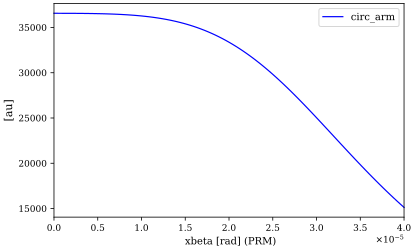

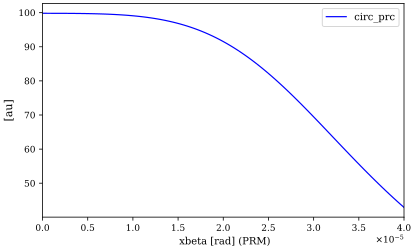

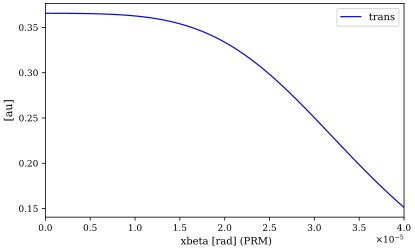

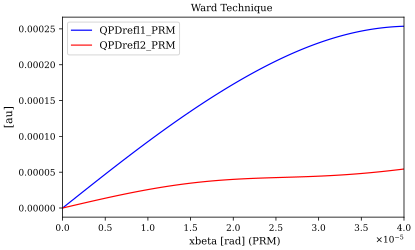

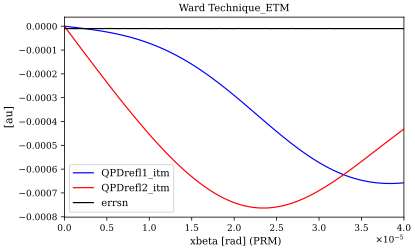

10.0
9.26336035131433
2.57218788055535
-7.149113321106019
-45.378493329543595


In [258]:
out_PRM.plot(['circ_arm'])
out_PRM.plot(['circ_prc'])
out_PRM.plot(['trans'])

out_PRM.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out_PRM.plot(['QPDrefl1_itm','QPDrefl2_itm','errsn'],title='Ward Technique_ETM')

#pl.figure(figsize=(6, 6))
#pl.subplot(211)
#pl.plot(out1.x,abs(out1["carHG00_ARM"]),label='car. HG00')
#pl.plot(out1.x,abs(out1["carHG01_ARM"]),label='car. HG01')
#pl.ylabel('Field amplitude [$\sqrt{W}$]')
#pl.title('Input beam pitch translation at cavity waist')
#pl.legend(prop={'size':24})
#pl.grid()
#pl.subplot(212)
#pl.plot(out1.x,pl.angle(out1["carHG00_ARM"])*180/pl.pi,label='car. HG00')
#pl.plot(out1.x,pl.angle(out1["carHG01_ARM"])*180/pl.pi,label='car. HG01')
#pl.xlabel('ETM')
#pl.ylabel('Field phase [deg]')
#pl.legend(prop={'size':24})
#pl.grid()
#
#
#pl.figure(figsize=(6, 6))
#pl.subplot(211)
#pl.plot(out1.x,abs(out1["carHG00_PRC"]),label='car. HG00')
#pl.plot(out1.x,abs(out1["carHG01_PRC"]),label='car. HG01')
#pl.ylabel('Field amplitude [$\sqrt{W}$]')
#pl.title('Input beam pitch translation at cavity waist')
#pl.legend(prop={'size':24})
#pl.grid()
#pl.subplot(212)
#pl.plot(out1.x,pl.angle(out1["carHG00_PRC"])*180/pl.pi,label='car. HG00')
#pl.plot(out1.x,pl.angle(out1["carHG01_PRC"])*180/pl.pi,label='car. HG01')
#pl.xlabel('ETM')
#pl.ylabel('Field phase [deg]')
#pl.legend(prop={'size':24})
#pl.grid()
print((out_PRM.x[25])*10e5)

print((out_PRM["QPDrefl1_PRM"][25]-out_PRM["QPDrefl1_PRM"][0])/(out_PRM.x[25]-out_PRM.x[0]))
print((out_PRM["QPDrefl2_PRM"][25]-out_PRM["QPDrefl2_PRM"][0])/(out_PRM.x[25]-out_PRM.x[0]))
print((out_PRM["QPDrefl1_itm"][25]-out_PRM["QPDrefl1_itm"][0])/(out_PRM.x[25]-out_PRM.x[0]))
print((out_PRM["QPDrefl2_itm"][25]-out_PRM["QPDrefl2_itm"][0])/(out_PRM.x[25]-out_PRM.x[0]))

In [259]:
print((out_PRM.x[25])*10e5)

10.0


Parsing `set err pop_I_raw re` into pykat object not implemented yet, added as extra line.
Parsing `set er8rs refl_I_f3 re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-11-04 12:12:37.880678


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 44.5743 seconds

--- Output info ---

Run date and time: 2022-11-04 12:12:37.880987
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl1_itm_1f, QPDrefl1_itm_3f, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, QPDrefl2_itm_1f, QPDrefl2_itm_3f, abcd, circ_arm, circ_prc, clocke, clocks, errs4, errsn, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ITM xbeta lin 0 4e-05 100']
QPDrefl1        : min = -2.955821650429280e-07 max = -0.000000000000000e+00
QPDrefl2        : min = -1.546876855723550e-08 max = 1.441545781578410e-10
QPDrefl1_itm_1f : min = -4.462813243040350e-05 max = -0.000000000000000e+00
QPDrefl2_itm_1f : min = -1.465475305276320e-07 max = 3.168305134084780e-06
QPDrefl1_itm    : min = 0.000000000000000e+00 max = 1.100919976559780e-04
QPDrefl2_itm    : min = 0.000000000000000e+00 max = 1.342638885577660e-03
QPDrefl1_itm_3f : min = -1.047601486932

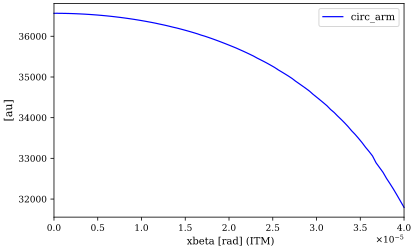

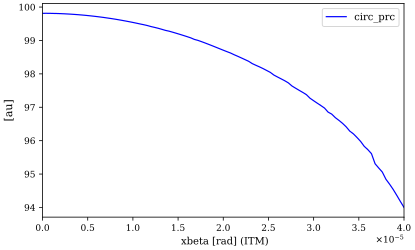

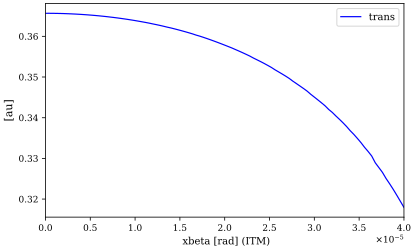

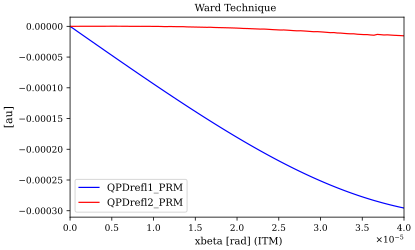

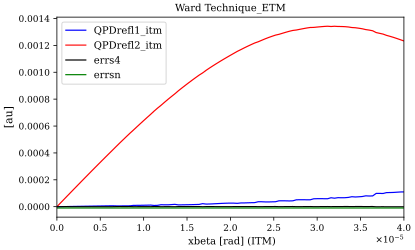

-9.372675570435
-0.0110613474371774
1.0700935830877498
64.0393793138897


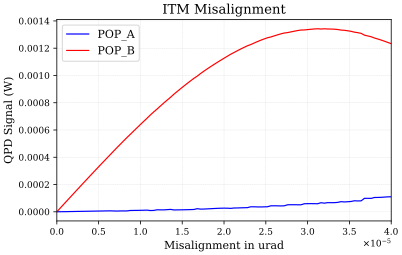

In [260]:
kat_ITM = kat.deepcopy()
kat_ITM.parse("""


#### LOCK ETM ####
set err pop_I_raw re
func errs4 = $err*0.00001
lock clocke $errs4 8.63 0.001m
put* ETM phi $clocke
noplot clocke
#####


set er8rs refl_I_f3 re
func errsn = $er8rs*100000
lock clocks $errsn 0.216 0.01m
put* PRM phi $clocks
noplot clocks

xaxis ITM xbeta lin 0 40u 100

#xaxis bs2 xbeta lin 0 20u 400
#func waisttilt = (-1)*0.5*$x1
#put bs1 xbeta $waisttilt

#yaxis lin abs:deg
#xaxis ETM phi lin 80 100 500

""")

out_ITM = kat_ITM.run()
out_ITM.info()
#out.plot()

out_ITM.plot(['circ_arm'])
out_ITM.plot(['circ_prc'])
out_ITM.plot(['trans'])

out_ITM.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out_ITM.plot(['QPDrefl1_itm','QPDrefl2_itm','errsn','errs4'],title='Ward Technique_ETM')

print((out_ITM["QPDrefl1_PRM"][25]-out_ITM["QPDrefl1_PRM"][0])/(out_ITM.x[25]-out_ITM.x[0]))
print((out_ITM["QPDrefl2_PRM"][25]-out_ITM["QPDrefl2_PRM"][0])/(out_ITM.x[25]-out_ITM.x[0]))
print((out_ITM["QPDrefl1_itm"][25]-out_ITM["QPDrefl1_itm"][0])/(out_ITM.x[25]-out_ITM.x[0]))
print((out_ITM["QPDrefl2_itm"][25]-out_ITM["QPDrefl2_itm"][0])/(out_ITM.x[25]-out_ITM.x[0]))

plt.plot(out_ITM.x,out_ITM["QPDrefl1_itm"],label="POP_A")
plt.plot(out_ITM.x,out_ITM["QPDrefl2_itm"],label="POP_B")
plt.xlabel('Misalignment in urad')
plt.ylabel('QPD Signal (W)')
#plt.xlim(-15,15)
plt.title("ITM Misalignment")
#plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.legend()
plt.show()

Parsing `set err pop_I_raw re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-11-04 12:13:25.221563


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 10.2202 seconds

--- Output info ---

Run date and time: 2022-11-04 12:13:25.221831
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl1_itm_1f, QPDrefl1_itm_3f, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, QPDrefl2_itm_1f, QPDrefl2_itm_3f, abcd, circ_arm, circ_prc, clocke, errs4, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ETM xbeta lin 0 4e-05 100']
QPDrefl1        : min = -0.000000000000000e+00 max = 5.296504566739820e-10
QPDrefl2        : min = -3.007396410450420e-10 max = 0.000000000000000e+00
QPDrefl1_itm_1f : min = -0.000000000000000e+00 max = 3.035600065683690e-06
QPDrefl2_itm_1f : min = -7.354386691559500e-07 max = 0.000000000000000e+00
QPDrefl1_itm    : min = 0.000000000000000e+00 max = 1.587282988436510e-04
QPDrefl2_itm    : min = -9.164155140350260e-04 max = 0.000000000000000e+00
QPDrefl1_itm_3f : min = -1.329794355231160e-08 max = 3.

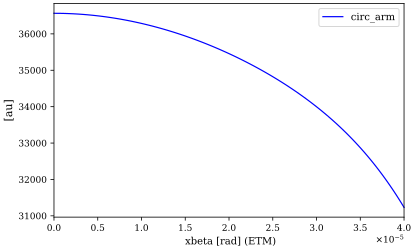

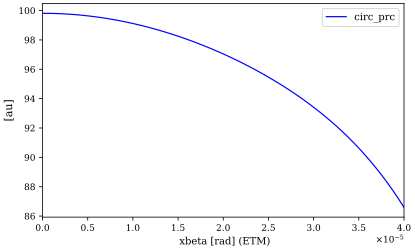

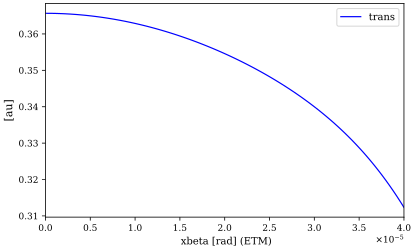

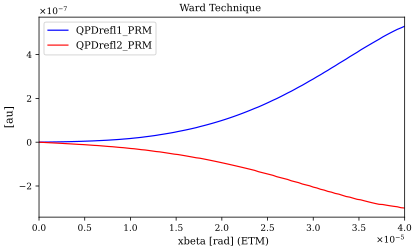

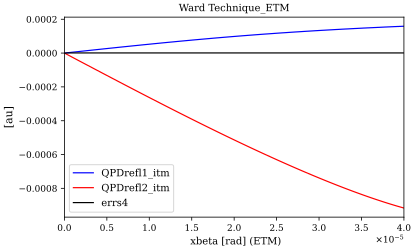

0.0016922197589474897
-0.0028699051635050397
5.245371110428359
-26.296347109960497


In [261]:
kat_ETM = kat.deepcopy()
kat_ETM.parse("""


#### LOCK ETM ####
set err pop_I_raw re
func errs4 = $err*0.00001
lock clocke $errs4 8.63 0.001m
put* ETM phi $clocke
noplot clocke
#####

xaxis ETM xbeta lin 0 40u 100

#xaxis bs2 xbeta lin 0 40u 500
#put bs1 xbeta $mx1

#yaxis lin abs:deg
#xaxis ETM phi lin 80 100 500

""")

out_ETM = kat_ETM.run()
out_ETM.info()
#out.plot()

out_ETM.plot(['circ_arm'])
out_ETM.plot(['circ_prc'])
out_ETM.plot(['trans'])

out_ETM.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out_ETM.plot(['QPDrefl1_itm','QPDrefl2_itm','errs4'],title='Ward Technique_ETM')

print((out_ETM["QPDrefl1_PRM"][25]-out_ETM["QPDrefl1_PRM"][0])/(out_ETM.x[25]-out_ETM.x[0]))
print((out_ETM["QPDrefl2_PRM"][25]-out_ETM["QPDrefl2_PRM"][0])/(out_ETM.x[25]-out_ETM.x[0]))
print((out_ETM["QPDrefl1_itm"][25]-out_ETM["QPDrefl1_itm"][0])/(out_ETM.x[25]-out_ETM.x[0]))
print((out_ETM["QPDrefl2_itm"][25]-out_ETM["QPDrefl2_itm"][0])/(out_ETM.x[25]-out_ETM.x[0]))

In [262]:
#i = 0
#tune = np.arange(0,360,20)
#slope_QPD1_itm = []
#slope_QPD2_itm = []
#slope_QPD1_prm = []
#slope_QPD2_prm = []
#
#for i in np.arange(0,360,20):
#    kat_xx = kat_ETM.deepcopy()
#    kat_xx.sQPD1.gouy = i
#    kat_xx.sQPD2.gouy = i+90
#    #kat_xy.sQPD11.gouy = i
#    #kat_xy.sQPD21.gouy = i+90
#    out_xx = kat_xx.run()
#    out_xy = kat_xy.run()
#    slope_QPD1_itm.append((out_xx["QPDrefl1_PRM"][5]-out_xx["QPDrefl1_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#    slope_QPD2_itm.append((out_xx["QPDrefl2_PRM"][5]-out_xx["QPDrefl2_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#    slope_QPD1_prm.append((out_xy["QPDrefl1_itm"][5]-out_xy["QPDrefl1_itm"][0])/(out_xy.x[5]-out_xy.x[0]))
#    slope_QPD2_prm.append((out_xy["QPDrefl2_itm"][5]-out_xy["QPDrefl2_itm"][0])/(out_xy.x[5]-out_xy.x[0]))
#    print(i)
#    out_xx.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique')
#    print((out_xx["QPDrefl1_PRM"][5]-out_xx["QPDrefl1_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#    print((out_xx["QPDrefl2_PRM"][5]-out_xx["QPDrefl2_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#      
#

In [263]:
#i = 0
#tune = np.arange(0,360,20)
#
#for i in np.arange(0,360,20):
#    kat_xx = kat_PRM.deepcopy()
#    kat_xy = kat_ITM.deepcopy()
#    kat_xx.s2.gouy = i
#    kat_xy.s2.gouy = i
#    #kat_xx.QPDrefl1.phase1 = i
#    #kat_xx.QPDrefl2.phase1 = i+90
#
#    #kat_xy.QPDrefl1.phase1 = i
#    #kat_xy.QPDrefl2.phase1 = i+90
#
#    out_xx = kat_xx.run()
#    out_xy = kat_xy.run()
#    out_xx.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique_PRM ')
#    out_xy.plot(['QPDrefl1_PRM','QPDrefl2_PRM','errs4'],title='Ward Technique_ITM')     
#    print(i)
#    print((out_xx["QPDrefl1_PRM"][5]-out_xx["QPDrefl1_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#    print((out_xx["QPDrefl2_PRM"][5]-out_xx["QPDrefl2_PRM"][0])/(out_xx.x[5]-out_xx.x[0]))
#    print((out_xy["QPDrefl1_PRM"][5]-out_xy["QPDrefl1_PRM"][0])/(out_xy.x[5]-out_xy.x[0]))
#    print((out_xy["QPDrefl2_PRM"][5]-out_xy["QPDrefl2_PRM"][0])/(out_xy.x[5]-out_xy.x[0]))
#    
#    
#

Parsing `set err42 pop_I_raw re` into pykat object not implemented yet, added as extra line.
Parsing `set er89s refl_I_f3 re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-11-04 12:13:37.951506


100% | ETA:  0:00:00 | Calculating - Locked ✓✓✓✓X (Locking steps tried 223/10000))

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 629.978 seconds

--- Output info ---

Run date and time: 2022-11-04 12:13:37.951813
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl1_itm_1f, QPDrefl1_itm_3f, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, QPDrefl2_itm_1f, QPDrefl2_itm_3f, abcd, circ_arm, circ_prc, clck, clks, clocke, clocks, er34, er45n, er8rs, errs4, errs999, ocks, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis bs2 xbeta lin 0 5e-06 2000']
QPDrefl1        : min = -0.000000000000000e+00 max = 1.088440077613420e-07
QPDrefl2        : min = -3.351023412862010e-10 max = 0.000000000000000e+00
QPDrefl1_itm_1f : min = -0.000000000000000e+00 max = 2.391328903549770e-05
QPDrefl2_itm_1f : min = 0.000000000000000e+00 max = 9.544947058244211e-07
QPDrefl1_itm    : min = -1.812300382033590e-05 max = 0.000000000000000e+00
QPDrefl2_itm    : min = -1.852862794031030e-04 max = 1.144358286770930e-06

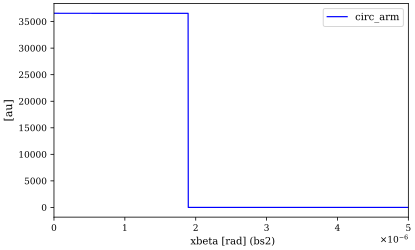

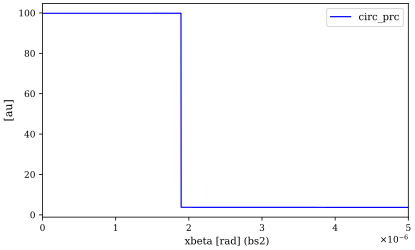

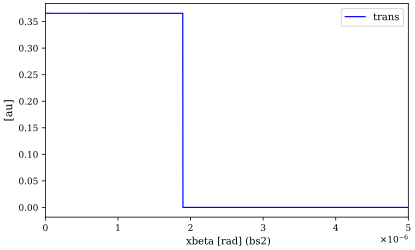

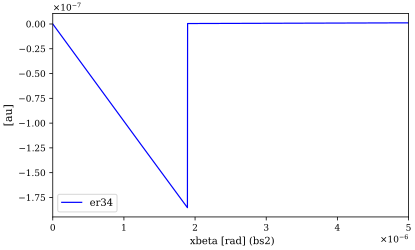

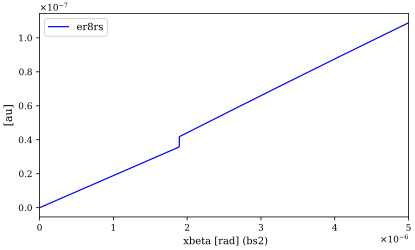

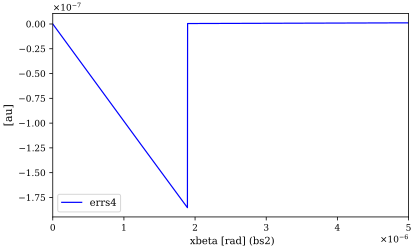

In [264]:
kat_asc = kat.deepcopy()
kat_asc.parse(""" 

xaxis bs2 xbeta lin 0 5u 2000
#func waisttilt = (0.05)*1*$x1
#put bs1 xbeta $waisttilt

#### LOCK ETM ####
#set err QPDrefl1_itm re
func errs4 = $erretm*0.001
lock clocke $errs4 -0.625 1m
put* ETM xbeta $clocke
#noplot clocke
#####

#### LOCK PRM ####

func er8rs = $abcd*0.001
lock clocks $er8rs -2.5 1m
put* PRM xbeta $clocks
#noplot clocks
#####


##### LOCK ITM ####
#set er8rs QPDrefl1_itm re
func er34 = $erretm*0.001
lock ocks $er34 -0.625 1m
put* ITM xbeta $ocks
#noplot ocks
#####
#





##### LOCK ETM ####
set err42 pop_I_raw re
func errs999 = $err42*0.00001
lock clck $errs999 8.63 0.001m
put* ETM phi $clck
#noplot clck
#####

#### LOCK PRM ####
set er89s refl_I_f3 re
func er45n = $er89s*100000
lock clks $er45n 0.216 0.001m
put* PRM phi $clks
#noplot clks
#####

""")

out_asc = kat_asc.run()
out_asc.info()
#out.plot()

out_asc.plot(['circ_arm'])
out_asc.plot(['circ_prc'])
out_asc.plot(['trans'])
#out_asc.plot(['clks','clck','ocks','clocke','clocks'])
#out_asc.plot(['er45n'])
#out_asc.plot(['errs999'])
out_asc.plot(['er34'])
out_asc.plot(['er8rs'])
out_asc.plot(['errs4'])


In [265]:
#out_asc.plot(['ocks','clocke','clocks'])